In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import pickle

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# === IMPORTS FOR SMOTE ===
# You may need to run: pip install imbalanced-learn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [3]:
processed_df = pd.read_pickle('/content/drive/My Drive/water-quality/processed_dataset_WQ.pkl')

In [ ]:
processed_df.shape

(53697, 24)

In [4]:
processed_df.columns

Index(['station_id', 'station_name', 'station_number', 'full_station_name',
       'station_type', 'latitude', 'longitude', 'county_name', 'sample_code',
       'sample_date', 'year', 'sample_depth_meter', 'DissolvedOxygen_mg/L',
       'SpecificConductance_µS/cm', 'Turbidity_NTU', 'WaterTemperature_°C',
       'pH_pH units', 'qi_DO', 'qi_pH', 'qi_Cond', 'qi_Turb', 'qi_Temp', 'WQI',
       'WQI_Class'],
      dtype='object')

In [6]:
processed_df[['station_name', 'station_type', 'DissolvedOxygen_mg/L', 'SpecificConductance_µS/cm', 'Turbidity_NTU', 'WaterTemperature_°C', 'pH_pH units']]

,station_name,station_type,DissolvedOxygen_mg/L,SpecificConductance_µS/cm,Turbidity_NTU,WaterTemperature_°C,pH_pH units
0,AMERICAN,Surface Water,12.18,66.0,2.28,10.18,7.60
1,AMERICAN,Surface Water,11.74,80.0,1.41,10.75,7.91
2,AMERICAN,Surface Water,13.04,52.0,160.00,9.24,7.26
3,AMERICAN,Surface Water,11.12,51.0,3.00,10.80,8.36
4,AMERICAN,Surface Water,11.46,64.8,2.10,11.00,7.71
...,...,...,...,...,...,...,...
53692,ETTSS-01 Lower,Groundwater,8.86,455.0,7.80,21.80,7.30
53693,ETTSS-01 Middle,Groundwater,8.86,333.0,7.80,21.30,6.90
53694,ETTSS-02 Upper,Groundwater,8.86,2.5,7.80,24.10,7.00
53695,ETTSS-02 Middle,Groundwater,8.86,273.0,7.80,18.30,7.20


# Model Training

In [ ]:
# Set global random state for reproducibility
RANDOM_STATE = 42

# ==========================================
# 1. DEFINE FEATURE ENGINEERING FUNCTION
# ==========================================
def engineer_features(df):
    # Create a copy to avoid SettingWithCopy warnings
    df = df.copy()

    # A. Temporal Features (Seasonality)
    if 'sample_date' in df.columns:
        df['sample_date'] = pd.to_datetime(df['sample_date'])
        df['Month'] = df['sample_date'].dt.month
        # Cyclical encoding: Dec (12) is close to Jan (1)
        df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)
        df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)

    # B. Interaction Features (Physics/Chemistry)
    # Oxygen Saturation Proxy: DO / Temp (Cold water holds more oxygen)
    # We add 1 to temp to avoid division by zero
    if 'DissolvedOxygen_mg/L' in df.columns and 'WaterTemperature_°C' in df.columns:
        df['DO_Temp_Ratio'] = df['DissolvedOxygen_mg/L'] / (df['WaterTemperature_°C'] + 1)

    # C. Handle Depth
    # Fill missing depth with 0 (assume surface if not recorded)
    if 'sample_depth_meter' in df.columns:
        df['sample_depth_meter'] = df['sample_depth_meter'].fillna(0)

    return df

# ==========================================
# 2. PREPARE DATA
# ==========================================

df = engineer_features(processed_df)

# Define the Feature Lists
numeric_features = [
    'DissolvedOxygen_mg/L', 'pH_pH units', 'Turbidity_NTU',
    'SpecificConductance_µS/cm', 'WaterTemperature_°C',
    'sample_depth_meter', 'DO_Temp_Ratio',
    'latitude', 'longitude',
    'Month_sin', 'Month_cos'
]

categorical_features = ['station_type']

target_col = 'WQI_Class'

# Filter X and y
X = df[numeric_features + categorical_features]
y = df[target_col]

# Encode Target (Good=0, Moderate=1, Poor=2)
le = LabelEncoder()
y = le.fit_transform(y)
class_names = [str(c) for c in le.classes_]

# Split Data (Stratify is crucial for the imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# ==========================================
# 3. BUILD PIPELINE (PREPROCESS -> SMOTE -> XGB)
# ==========================================

# Numeric Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)



In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


RANDOM_STATE = 42

# --- 1. Define the Classifiers to Test ---
classifiers = {
    "XGBoost (Current)": XGBClassifier(
        objective='multi:softmax', num_class=len(class_names),
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, eval_metric='mlogloss',
        n_jobs=-1, random_state=RANDOM_STATE
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=400, max_depth=15, min_samples_leaf=5,
        class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE
    ),
    "Logistic Regression": LogisticRegression(
        max_iter=3000, multi_class='auto', class_weight='balanced',
        n_jobs=-1, random_state=RANDOM_STATE
    ),
    "SVM (RBF Kernel)": SVC(
        kernel='rbf', C=1.5, gamma='scale', class_weight='balanced',
        random_state=RANDOM_STATE, probability=True
    )
}

# --- 2. Initialize result storage ---
all_results = []  # store per-model, per-split metrics

print("Starting Model Comparison (SMOTE + Enhanced Features Applied to All)\n")

base_steps = [
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE, k_neighbors=5))
]

for name, classifier in classifiers.items():
    print(f"--- Training {name} ---")
    pipeline = ImbPipeline(steps=base_steps + [('clf', classifier)])
    pipeline.fit(X_train, y_train)

    for split_name, (X, y_true) in [('Train', (X_train, y_train)), ('Test', (X_test, y_test))]:
        y_pred = pipeline.predict(X)
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)

        # Extract all class metrics, not just “Poor”
        for cls in class_names:
            all_results.append({
                'Model': name,
                'Split': split_name,
                'Class': cls,
                'Accuracy': accuracy_score(y_true, y_pred),
                'Precision': report[cls]['precision'],
                'Recall': report[cls]['recall'],
                'F1': report[cls]['f1-score'],
                'Support': report[cls]['support']
            })

        print(f"\n[{name}] {split_name} Results:")
        print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    print("\n" + "="*60 + "\n")

# --- 3. Create and summarize DataFrame ---
all_results_df = pd.DataFrame(all_results)

# Optional: pivot for a compact comparison
summary_df = (
    all_results_df
    .query("Class == 'Poor'")
    .pivot(index='Model', columns='Split', values='F1')
    .assign(F1_Gap=lambda df: df['Test'] - df['Train'])
    .sort_values(by='Test', ascending=False)
)

print("\n\n--- Summary (F1 for 'Poor' Class) ---")
# print(summary_df)

# --- Save to CSV ---
# all_results_df.to_csv("model_comparison_detailed_metrics.csv", index=False)
# summary_df.to_csv("model_summary_poor_f1.csv")

print("\nSaved detailed and summary results to CSV files.")


Starting Model Comparison (SMOTE + Enhanced Features Applied to All)

--- Training XGBoost (Current) ---

[XGBoost (Current)] Train Results:
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00     18713
    Moderate       1.00      1.00      1.00     24045
        Poor       1.00      1.00      1.00       199

    accuracy                           1.00     42957
   macro avg       1.00      1.00      1.00     42957
weighted avg       1.00      1.00      1.00     42957


[XGBoost (Current)] Test Results:
              precision    recall  f1-score   support

        Good       0.98      0.99      0.99      4678
    Moderate       0.99      0.99      0.99      6012
        Poor       0.88      0.90      0.89        50

    accuracy                           0.99     10740
   macro avg       0.95      0.96      0.95     10740
weighted avg       0.99      0.99      0.99     10740



--- Training Random Forest ---

[Random Forest] Train Result

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



[Logistic Regression] Train Results:
              precision    recall  f1-score   support

        Good       0.91      0.96      0.93     18713
    Moderate       0.96      0.89      0.92     24045
        Poor       0.16      0.97      0.28       199

    accuracy                           0.92     42957
   macro avg       0.68      0.94      0.71     42957
weighted avg       0.94      0.92      0.93     42957


[Logistic Regression] Test Results:
              precision    recall  f1-score   support

        Good       0.91      0.95      0.93      4678
    Moderate       0.96      0.89      0.92      6012
        Poor       0.17      0.98      0.29        50

    accuracy                           0.92     10740
   macro avg       0.68      0.94      0.71     10740
weighted avg       0.94      0.92      0.92     10740



--- Training SVM (RBF Kernel) ---

[SVM (RBF Kernel)] Train Results:
              precision    recall  f1-score   support

        Good       0.90      0.96    

In [ ]:
# save_path = '/content/drive/My Drive/water-quality/model_results.csv'
# all_results_df.to_csv(save_path, index=False)


In [ ]:
all_results_df

,Model,Split,Class,Accuracy,Precision,Recall,F1,Support
0,XGBoost (Current),Train,Good,0.999884,0.999840,0.999893,0.999866,18713.0
1,XGBoost (Current),Train,Moderate,0.999884,0.999917,0.999875,0.999896,24045.0
2,XGBoost (Current),Train,Poor,0.999884,1.000000,1.000000,1.000000,199.0
3,XGBoost (Current),Test,Good,0.986406,0.982784,0.988457,0.985612,4678.0
4,XGBoost (Current),Test,Moderate,0.986406,0.990140,0.985529,0.987829,6012.0
5,XGBoost (Current),Test,Poor,0.986406,0.882353,0.900000,0.891089,50.0
6,Random Forest,Train,Good,0.984938,0.977862,0.989045,0.983422,18713.0
7,Random Forest,Train,Moderate,0.984938,0.991389,0.981618,0.986479,24045.0
8,Random Forest,Train,Poor,0.984938,0.896396,1.000000,0.945368,199.0
9,Random Forest,Test,Good,0.966201,0.957595,0.970286,0.963899,4678.0


# XGB - Best Model

In [ ]:
# ==========================================
# 4. TRAIN AND EVALUATE
# ==========================================
# Main Pipeline
model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    # SMOTE creates synthetic 'Poor' samples ONLY in the training set
    ('smote', SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
    ('clf', XGBClassifier(
        objective='multi:softmax',
        num_class=len(class_names),
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

print("Training Enhanced XGBoost with SMOTE...")
model.fit(X_train, y_train)

print("Predicting...")
y_pred = model.predict(X_test)

y_train_pred = model.predict(X_train)

print("\n[XGBoost + SMOTE] TRAIN RESULTS")
print(classification_report(y_train, y_train_pred, target_names=class_names))

print("\n--- TEST RESULTS ---")
print(classification_report(y_test, y_pred, target_names=class_names))


# print("\nConfusion Matrix:")
# print(confusion_matrix(y_test, y_pred))



# Saving to pickle file

# import joblib

# # Save model and label encoder to Google Drive or local path
# joblib.dump(model, 'wqi_xgb_pipeline.pkl')
# joblib.dump(le, 'label_encoder.pkl')

# print("Model and label encoder saved successfully.")

# joblib.dump(model, '/content/drive/My Drive/water-quality/wqi_xgb_pipeline.pkl')
# joblib.dump(le, '/content/drive/My Drive/water-quality/label_encoder.pkl')


Training Enhanced XGBoost with SMOTE...
Predicting...

[XGBoost + SMOTE] TRAIN RESULTS
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00     18713
    Moderate       1.00      1.00      1.00     24045
        Poor       1.00      1.00      1.00       199

    accuracy                           1.00     42957
   macro avg       1.00      1.00      1.00     42957
weighted avg       1.00      1.00      1.00     42957


--- TEST RESULTS ---
              precision    recall  f1-score   support

        Good       0.98      0.99      0.99      4678
    Moderate       0.99      0.99      0.99      6012
        Poor       0.88      0.90      0.89        50

    accuracy                           0.99     10740
   macro avg       0.95      0.96      0.95     10740
weighted avg       0.99      0.99      0.99     10740



### Plotting Feature Importance

/tmp/ipython-input-3368191285.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')


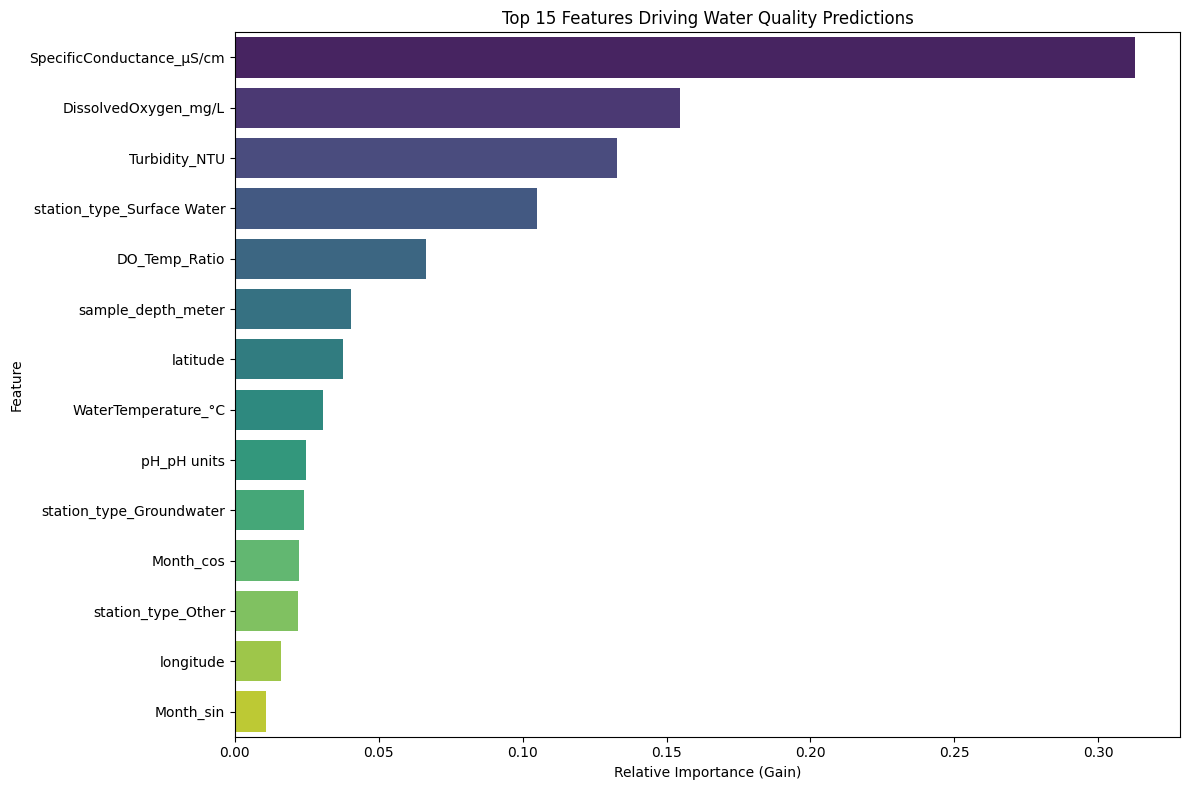


Top 10 Most Important Features:
                       Feature  Importance
3    SpecificConductance_µS/cm    0.312796
0         DissolvedOxygen_mg/L    0.154594
2                Turbidity_NTU    0.132802
13  station_type_Surface Water    0.105013
6                DO_Temp_Ratio    0.066561
5           sample_depth_meter    0.040383
7                     latitude    0.037629
4          WaterTemperature_°C    0.030781
1                  pH_pH units    0.024632
11    station_type_Groundwater    0.023930


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract the Feature Names
preprocessor = model.named_steps['preprocessor']

feature_names = preprocessor.get_feature_names_out()

clean_feature_names = [name.split('__')[-1] for name in feature_names]

# 2. Extract Importance Scores from the XGBoost model
xgb_model = model.named_steps['clf']
importances = xgb_model.feature_importances_

# 3. Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': clean_feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 4. Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Features Driving Water Quality Predictions')
plt.xlabel('Relative Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 5. Print the top 10 textual list
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

In [ ]:
import shap
# Extract the trained classifier and preprocessor
xgb_model = model.named_steps['clf']
preprocessor = model.named_steps['preprocessor']

In [ ]:
# Transform X_test through the preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Recover transformed feature names
num_features = preprocessor.transformers_[0][2]
cat_encoder = preprocessor.transformers_[1][1].named_steps['encoder']
cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])

# Combine numeric + encoded categorical features
all_feature_names = np.concatenate([num_features, cat_features])


In [ ]:
# Create SHAP explainer for tree-based XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for transformed test data
shap_values = explainer.shap_values(X_test_transformed)


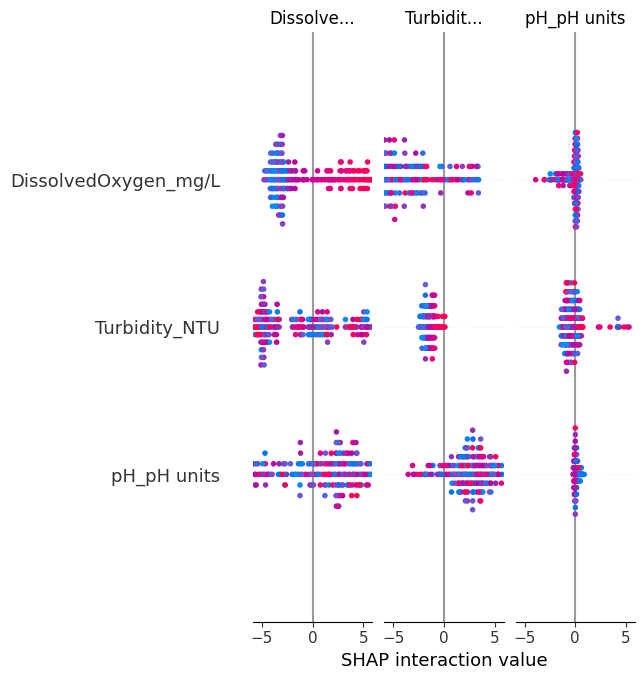

In [ ]:
# Summary plot: shows global feature importance + effect direction
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names)


The SHAP interaction plot confirms that the predictive power of the model does not rely on features in isolation.

The combination of High Turbidity and Low Dissolved Oxygen is the most toxic combination, resulting in a strong positive force (high SHAP value) toward the Poor water quality prediction.

pH plays a critical modifying role: acidic (Low pH) conditions intensify the likelihood of Poor quality, while alkaline (High pH) conditions provide a mitigating, or neutralizing, effect.

### For one test datapoint

In [ ]:
# Sample data
test_data = {
 'latitude': 38.5358,
 'longitude': -121.5206,
 'station_type': 'Surface Water',
 'sample_date': '2011-12-29 08:30:00',
 'sample_depth_meter': 1.0,
 'DissolvedOxygen_mg/L': 8.86,
 'SpecificConductance_µS/cm': 375.0,
 'Turbidity_NTU': 7.8,
 'WaterTemperature_°C': 8.0,
 'pH_pH units': 7.71}

test_dp = pd.DataFrame([test_data])

Predicted WQI_Class: Moderate


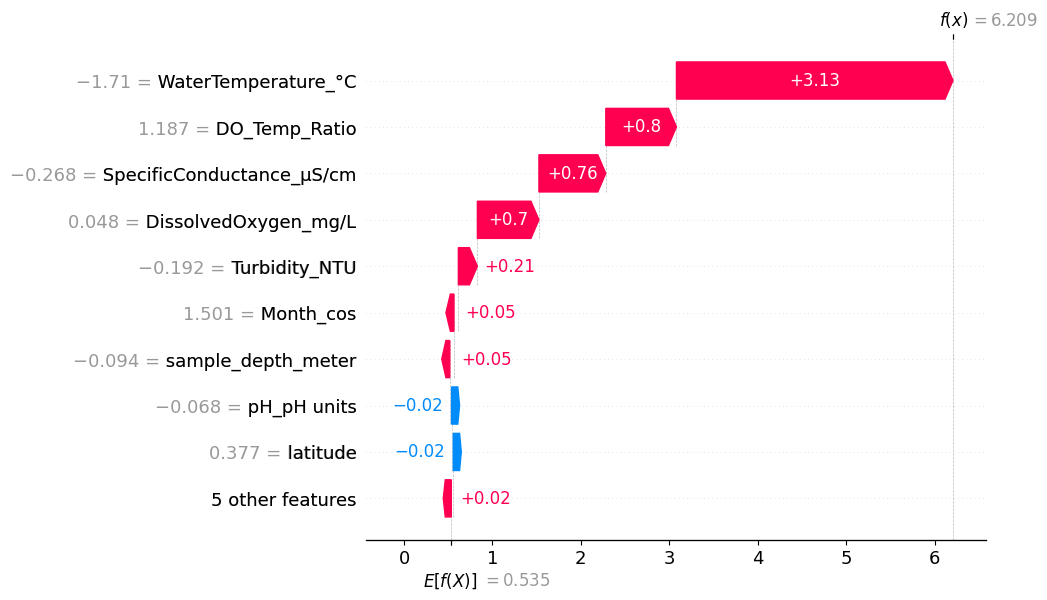

In [ ]:
# --- 1. Apply feature engineering ---
test_dp_processed = engineer_features(test_dp)

# --- 2. Select model input columns ---
input_features = [
    'DissolvedOxygen_mg/L', 'pH_pH units', 'Turbidity_NTU',
    'SpecificConductance_µS/cm', 'WaterTemperature_°C',
    'sample_depth_meter', 'DO_Temp_Ratio',
    'latitude', 'longitude', 'Month_sin', 'Month_cos',
    'station_type'
]
test_input = test_dp_processed[input_features]

# --- 3. Predict class ---
encoded_pred = model.predict(test_input)
decoded_pred = le.inverse_transform(encoded_pred)
print("Predicted WQI_Class:", decoded_pred[0])

# --- 4. SHAP analysis ---
import shap
import numpy as np

xgb_model = model.named_steps['clf']
preprocessor = model.named_steps['preprocessor']

# Transform using the same preprocessor
test_transformed = preprocessor.transform(test_input)

# Get feature names
num_features = preprocessor.transformers_[0][2]
cat_encoder = preprocessor.transformers_[1][1].named_steps['encoder']
cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])
all_feature_names = np.concatenate([num_features, cat_features])

# Compute SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(test_transformed)

# Handle multi-class output for TreeExplainer where shap_values is a numpy array of shape (N, F, C)
# or a list of arrays (C of (N, F)) for other explainers.
# For TreeExplainer with multi-output, shap_values typically returns a list of arrays, one for each output.
# However, the kernel state indicates shap_values is a single array of shape (1, 14, 3).

# Get the index of the predicted class
predicted_class_idx = int(encoded_pred[0])

# Extract SHAP values for the single instance and the predicted class
# If shap_values is a numpy array of shape (1, num_features, num_classes)
shap_values_for_class = shap_values[0, :, predicted_class_idx]
# Extract the base value for the predicted class
base_value_for_class = explainer.expected_value[predicted_class_idx]

# Plot
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_for_class,
        base_values=base_value_for_class, # Use the base value specific to the predicted class
        feature_names=all_feature_names,
        data=test_transformed[0]
    )
)
